# Prerequisites

Before running this notebook, the following tasks must be completed:

1. Download the snmC-seq2 data by running `data/liu_2021_download.py` with `--region=HPF`
2. Download the snm3C-seq data by running `data/liu_2021_snm3C-seq.py`
3. Create the merged dataset by running `data/liu_2021_mixed.py`
4. Run `experiment_scripts/run_integration_experiment.py` for each baseline model
5. Run `experiment_scripts/calculate_integration_metrics.py`

In [1]:
import mudata
import scanpy as sc
import pickle
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

mdata = mudata.read_h5mu(
    "/projects/leelab3/methylVI/Liu2021_mixed/data/gene_2500_features.h5mu"
)

In [2]:
per_model_batch_correction_metrics_dicts = {}
per_model_bio_conservation_metrics_dicts = {}

models = ['methylVI', 'mnn', 'harmony', 'scanorama', 'seurat', 'unintegrated']

for model in models:
    per_model_batch_correction_metrics_dicts[model] = pickle.load(
        open(f"/projects/leelab3/methylVI/Liu2021_mixed/{model}_batch_correction_metrics.pkl", "rb")
    )

    per_model_bio_conservation_metrics_dicts[model] = pickle.load(
        open(f"/projects/leelab3/methylVI/Liu2021_mixed/{model}_bio_conservation_metrics.pkl", "rb")
    )

batch_correction_metrics_dict = defaultdict(defaultdict(int).copy)
batch_correction_metric_names = per_model_batch_correction_metrics_dicts[models[0]].keys()

for metric in batch_correction_metric_names:
    for model in models:
        batch_correction_metrics_dict[metric][model] = per_model_batch_correction_metrics_dicts[model][metric]

bio_conservation_metrics_dict = defaultdict(defaultdict(int).copy)
bio_conservation_metric_names = per_model_bio_conservation_metrics_dicts[models[0]].keys()
for metric in bio_conservation_metric_names:
    for model in models:
        bio_conservation_metrics_dict[metric][model] = per_model_bio_conservation_metrics_dicts[model][metric]

In [3]:
bio_conservation_score_matrix = pd.DataFrame(bio_conservation_metrics_dict)
batch_correction_score_matrix = pd.DataFrame(batch_correction_metrics_dict)

In [4]:
bio_conservation_score_matrix = pd.DataFrame(
    data=MinMaxScaler().fit_transform(bio_conservation_score_matrix),
    index=bio_conservation_score_matrix.index,
    columns=bio_conservation_score_matrix.columns
)
bio_conservation_total_name = "Bio-Conservation\nScore"
bio_conservation_score_matrix[bio_conservation_total_name] = bio_conservation_score_matrix.mean(axis=1)
bio_conservation_score_matrix = bio_conservation_score_matrix[[bio_conservation_total_name] + [col for col in bio_conservation_score_matrix.columns if col != bio_conservation_total_name]]

batch_correction_score_matrix = pd.DataFrame(
    data=MinMaxScaler().fit_transform(batch_correction_score_matrix),
    index=batch_correction_score_matrix.index,
    columns=batch_correction_score_matrix.columns
)
batch_correction_total_name = "Batch\nCorrection\nScore"
batch_correction_score_matrix[batch_correction_total_name] = batch_correction_score_matrix.mean(axis=1)
batch_correction_score_matrix = batch_correction_score_matrix[[batch_correction_total_name] + [col for col in batch_correction_score_matrix.columns if col != batch_correction_total_name]]


total_score_matrix = pd.concat([batch_correction_score_matrix, bio_conservation_score_matrix], axis=1)
total_quality_name = "Overall\nScore"
total_score_matrix.insert(
    0,
    total_quality_name,
    (0.4*batch_correction_score_matrix[batch_correction_total_name] + 0.6*bio_conservation_score_matrix[bio_conservation_total_name]).values
)

In [5]:
total_score_matrix.rename(
    index={
        "mnn": "fastMNN",
        "unintegrated": "Unintegrated",
        "scanorama": "Scanorama",
        "harmony": "Harmony",
        "seurat": "Seurat"
    },
    inplace=True
)

In [6]:
total_score_matrix.sort_values(by='Overall\nScore', ascending=False, inplace=True)

In [7]:
dot_color_df = total_score_matrix.assign(**total_score_matrix.iloc[:, 0:].rank(axis = 0).astype(int))

In [8]:
dot_color_df = dot_color_df / dot_color_df.shape[0]

In [9]:
total_score_matrix

,Overall\nScore,Batch\nCorrection\nScore,kBET,Graph iLISI,Batch ASW,Graph connectivity,PCR batch,Bio-Conservation\nScore,Cell type ARI,Cell type NMI,Cell type ASW,Isolated label F1,Isolated label ASW,Graph cLISI
methylVI,0.802244,0.755611,1.000000,0.694292,1.000000,0.324297,0.759464,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
Harmony,0.459838,0.351141,0.353425,0.243004,0.473625,0.000000,0.685649,0.532303,0.832179,0.835005,0.676054,0.714157,0.136426,0.0
fastMNN,0.430465,0.730254,0.502903,0.565628,0.941077,0.791088,0.850573,0.230607,0.306085,0.386589,0.000000,0.659059,0.031906,0.0
Scanorama,0.422157,0.370777,0.000000,1.000000,0.472046,0.381839,0.000000,0.456411,0.561025,0.283179,0.740269,0.717296,0.436696,0.0
Unintegrated,0.348246,0.237567,0.187837,0.000000,0.000000,1.000000,0.000000,0.422031,0.842047,0.426456,0.638343,0.624272,0.001067,0.0
Seurat,0.256860,0.639204,0.453352,0.563408,0.779540,0.399721,1.000000,0.001964,0.000000,0.000000,0.011785,0.000000,0.000000,0.0


In [10]:
batch_correction_metric_column_idxs = [2, 3, 4, 5, 6]
bio_conservation_metric_column_idxs = [8, 9, 10, 11, 12, 13]

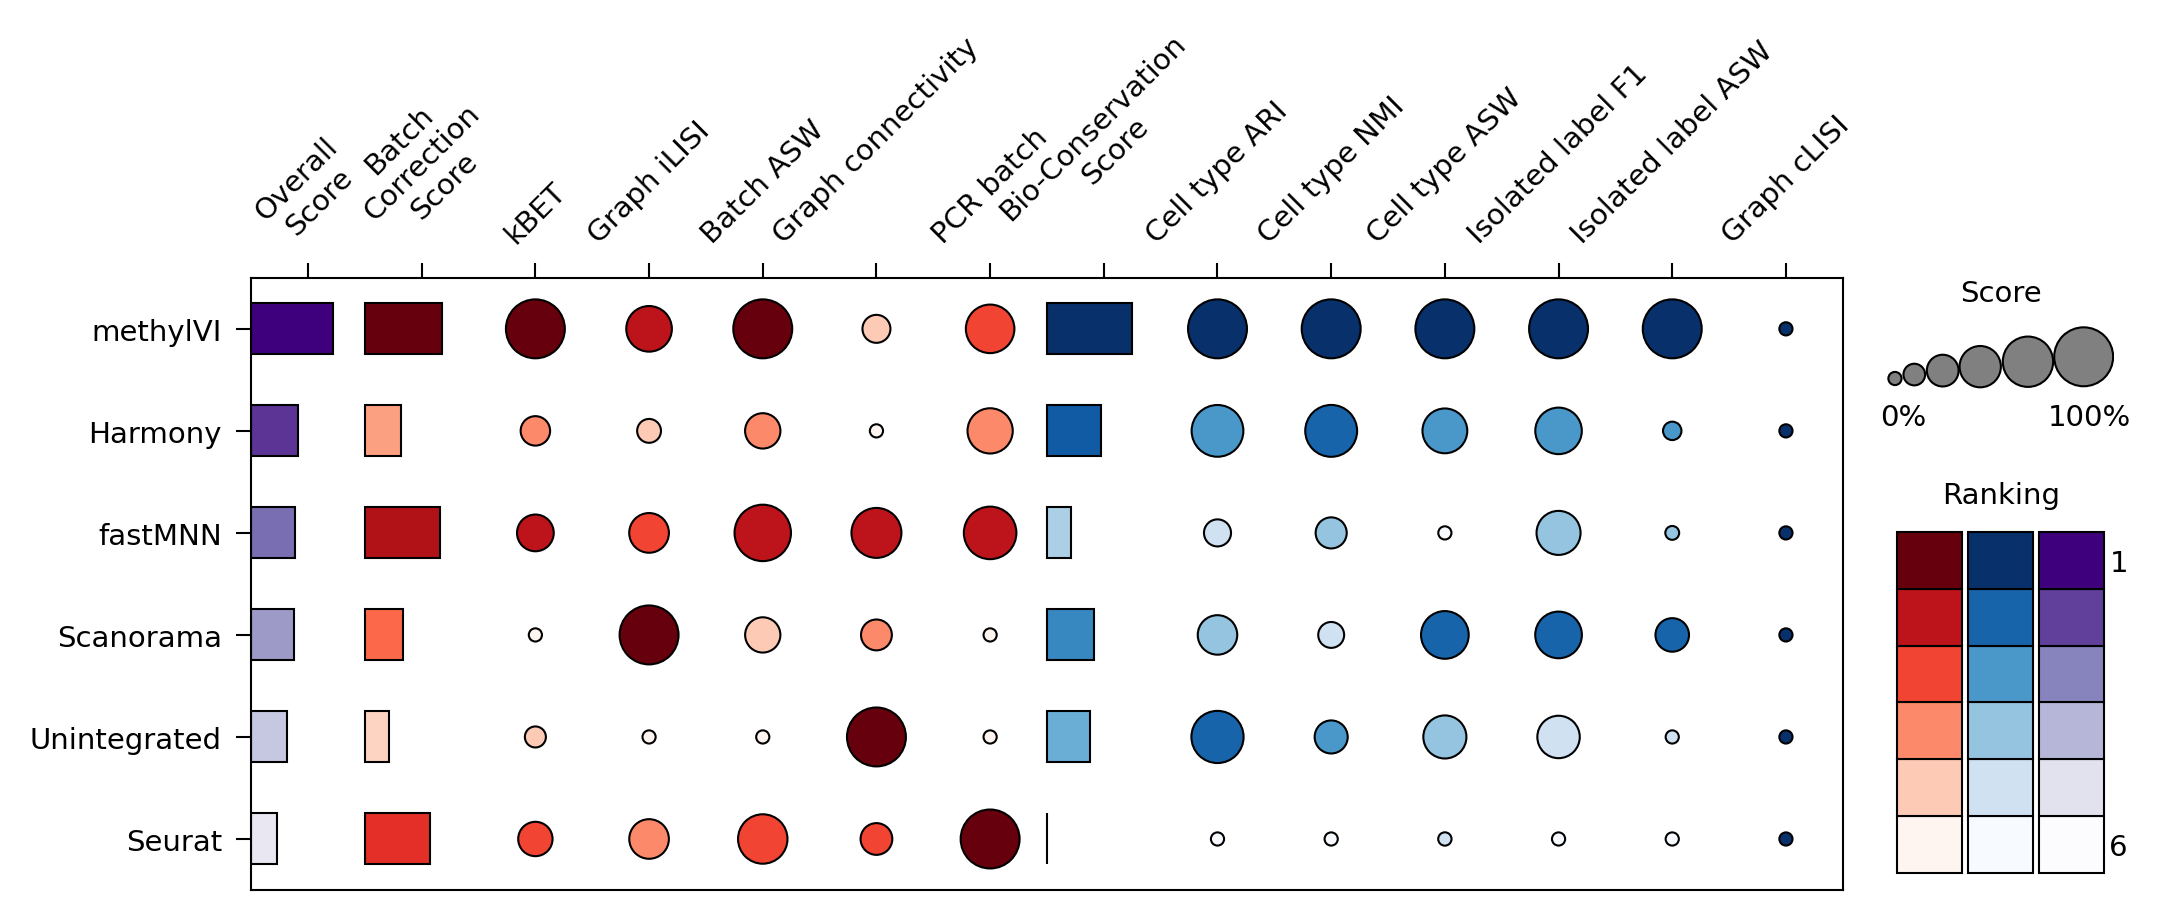

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Circle
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as coll
sc._settings.settings._vector_friendly = True

mm = 1/25.4

fontsize = 7
border_width = 0.5
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'axes.titlesize': fontsize})
matplotlib.rcParams['font.family'] = 'sans-serif'
largest_dot = 200
smallest_dot = 10
size_exponent = 1.5


n_metrics = dot_color_df.shape[1]
n_models = dot_color_df.shape[0]

legend_buffer = 2
fig = plt.figure(constrained_layout=True, figsize=(n_metrics + legend_buffer, n_models+0.5), dpi=300)
fig.set_size_inches(180 * mm, 75 * mm)

gs = GridSpec(n_models, n_metrics+legend_buffer, figure=fig)

dot_ax = fig.add_subplot(gs[:n_models, :n_metrics])
size_legend_ax = fig.add_subplot(gs[0:2, n_metrics:])
rank_legend_ax = fig.add_subplot(gs[2:6, n_metrics:])

salient_cmap = cm.Reds
for idx in batch_correction_metric_column_idxs:
    
    column = total_score_matrix.iloc[:, idx]
    x = [idx + 0.5 for _ in range(column.shape[0])] 
    y = np.arange(column.shape[0]) + 0.5
    
    size = total_score_matrix.iloc[:, idx]
    size = size**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot
    
    color = dot_color_df.iloc[:, idx]
    
    dot_ax.scatter(
        x,
        y,
        s=size,
        linewidth=border_width,
        c=color,
        cmap=salient_cmap,
        edgecolor='black'
    )
    
shared_cmap = cm.Blues
for idx in bio_conservation_metric_column_idxs:
    column = total_score_matrix.iloc[:, idx]
    x = [idx + 0.5 for _ in range(column.shape[0])] 
    y = np.arange(column.shape[0]) + 0.5
    
    size = total_score_matrix.iloc[:, idx]
    size = size**size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot


    # All the graph cLISI's are the same, which leads to an edge
    # case in the dot coloring. Here we manually fix all dots to have
    # the same (dark blue) coloring.
    if idx == 13:
        color = dot_color_df.iloc[:, idx]

        dot_ax.scatter(
            x,
            y,
            s=size,
            linewidth=border_width,
            color=shared_cmap(1.0),
            edgecolor='black'
        )
    
    else:
        color = dot_color_df.iloc[:, idx]
        
        dot_ax.scatter(
            x,
            y,
            s=size,
            linewidth=border_width,
            c=color,
            cmap=shared_cmap,
            edgecolor='black'
        )
        


y_ticks = np.arange(dot_color_df.shape[0]) + 0.5
dot_ax.set_yticks(y_ticks)
dot_ax.set_yticklabels(
    [dot_color_df.index[idx] for idx, _ in enumerate(y_ticks)], minor=False, fontsize=fontsize
)

x_ticks = np.arange(dot_color_df.shape[1]) + 0.5
dot_ax.set_xticks(x_ticks)
dot_ax.set_xticklabels(
    [dot_color_df.columns[idx] for idx, _ in enumerate(x_ticks)],
    rotation=45,
    ha='center',
    minor=False,
    fontsize=fontsize
)
dot_ax.tick_params(axis='both', labelsize=fontsize, width=border_width)
dot_ax.grid(False)


# to be consistent with the heatmap plot, is better to
# invert the order of the y-axis, such that the first group is on
# top
dot_ax.set_ylim(dot_color_df.shape[0], 0)
dot_ax.set_xlim(0, dot_color_df.shape[1])
dot_ax.xaxis.tick_top()

total_cmap = cm.Purples
for idx in range(dot_color_df.shape[0]):
    width = total_score_matrix[total_score_matrix.columns[0]][idx]
    color = dot_color_df[total_score_matrix.columns[0]][idx]
    
    dot_ax.add_patch(
        Rectangle(
            xy=(0, idx + 0.25),
            width=width*0.9,
            height=0.5,
            linewidth=border_width,
            facecolor=total_cmap(color),
            edgecolor='black'
        )
    )

for idx in range(dot_color_df.shape[0]):
    width = total_score_matrix[total_score_matrix.columns[1]][idx]
    color = dot_color_df[total_score_matrix.columns[1]][idx]
    
    dot_ax.add_patch(
        Rectangle(
            xy=(1, idx + 0.25),
            width=width*0.9,
            height=0.5,
            linewidth=border_width,
            facecolor=salient_cmap(color),
            edgecolor='black'
        )
    )
    
for idx in range(dot_color_df.shape[0]):
    width = total_score_matrix[total_score_matrix.columns[7]][idx]
    color = dot_color_df[total_score_matrix.columns[7]][idx]
    
    dot_ax.add_patch(
        Rectangle(
            xy=(7, idx + 0.25),
            width=width*0.9,
            height=0.5,
            linewidth=border_width,
            facecolor=shared_cmap(color),
            edgecolor='black'
        )
    )

for axis in ['top', 'bottom', 'left', 'right']:
    dot_ax.spines[axis].set_linewidth(border_width)
    
# Size legend
diff = 1.0
step = 0.2
# a descending range that is afterwards inverted is used
# to guarantee that dot_max is in the legend.
size_values = np.arange(1, 0 - step, step * -1)[::-1]
size_range = size_values

size = size_values**size_exponent
size = size * (largest_dot - smallest_dot) + 10

# plot size bar
xpos = np.array([0.03, 0.115, 0.24, 0.405, 0.615, 0.86]) + 0.005
ypos = [-1.1, -.9, -0.7, -0.5, -0.25, 0]
#xpos = np.array([0, 0.075, 0.2, 0.365, 0.575, 0.825]) + 0.02
#ypos = [-1.1, -.9, -0.7, -0.5, -0.25, 0]

size_legend_ax.scatter(
    xpos,
    ypos,
    s=size,
    color='gray',
    edgecolor='black',
    linewidth=border_width,
)
xticks = [xpos[0]+0.035, xpos[-1]+0.025]
size_legend_ax.set_xticks(xticks)
size_legend_ax.xaxis.set_tick_params(length=0)
labels = ["0%", "100%"]

size_legend_ax.set_xticklabels(labels, fontsize=fontsize, y=0.2)

# remove y ticks and labels
size_legend_ax.tick_params(
    axis='y', left=False, labelleft=False, labelright=False
)

# remove surrounding lines
for spine in ['right', 'top', 'left', 'bottom']:
    size_legend_ax.spines[spine].set_visible(False)
size_legend_ax.grid(False)

ymax = size_legend_ax.get_ylim()[1]
size_legend_ax.set_ylim(-3, 4)
xmin, xmax = size_legend_ax.get_xlim()
size_legend_ax.set_xlim(0, 1.0)
#ax.set_xlim(xmin - 0.15, xmax + 0.5)
size_legend_ax.set_title("Score", fontsize=fontsize, y=0.65)

wid = 0.2
hei = 0.1
nrows = total_score_matrix.shape[0]
inbetween = 0.02

shade = np.linspace(0, 1, nrows)

cmaps = [cm.Reds, cm.Blues, cm.Purples]
ncols = len(cmaps)

for col in range(ncols):
    cmap = cmaps[col]
    for i, row in enumerate(range(nrows)):
        sq = patches.Rectangle(
            (col*(wid+inbetween), row*(hei)),
            wid,
            hei,
            fill=True,
            edgecolor='black',
            facecolor=cmap(shade[i]),
            linewidth=border_width
        )
        rank_legend_ax.add_patch(sq)

rank_legend_ax.relim()
rank_legend_ax.autoscale_view()

rank_legend_ax.set_xticks([])
rank_legend_ax.set_yticks([0.05, 0.55])
rank_legend_ax.set_yticklabels([dot_color_df.shape[0], 1], fontsize=fontsize, x=0.85)
rank_legend_ax.yaxis.set_label_position("right")
rank_legend_ax.yaxis.tick_right()
rank_legend_ax.yaxis.set_ticks_position('none') 


for spine in ['top', 'bottom', 'left', 'right']:
    rank_legend_ax.spines[spine].set_visible(False)

rank_legend_ax.set_title("Ranking", fontsize=fontsize, y=0.965)

fig.savefig("integration_quantitative.pdf", dpi=300, transparent=True)

In [12]:
import numpy as np
from sklearn.preprocessing import normalize

mdata.obsm['methylVI'] = np.load(
    "/projects/leelab2/metVI/results/Liu2021_mixed_integration/gene/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/123/latent_representations.npy"
)

sc.pp.pca(mdata['mCG'])
sc.pp.pca(mdata['mCH'])

mdata.obsm['unintegrated'] = np.concatenate([
    mdata['mCG'].obsm['X_pca'] / mdata['mCG'].obsm['X_pca'].std(),
    mdata['mCH'].obsm['X_pca'] / mdata['mCH'].obsm['X_pca'].std()
], axis=1)

In [13]:
sc.pp.neighbors(mdata, use_rep='unintegrated')
sc.tl.umap(mdata)
mdata.obsm['pca_umap'] = mdata.obsm['X_umap']

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sc.pp.neighbors(mdata, use_rep="methylVI")
sc.tl.umap(mdata)
mdata.obsm[f'methylVI_umap'] = mdata.obsm['X_umap']

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Circle
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as coll
sc._settings.settings._vector_friendly = True

mm = 1/25.4

fontsize = 7
border_width = 0.5
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'axes.titlesize': fontsize})
matplotlib.rcParams['font.family'] = 'sans-serif'
largest_dot = 200
smallest_dot = 10
size_exponent = 1.5

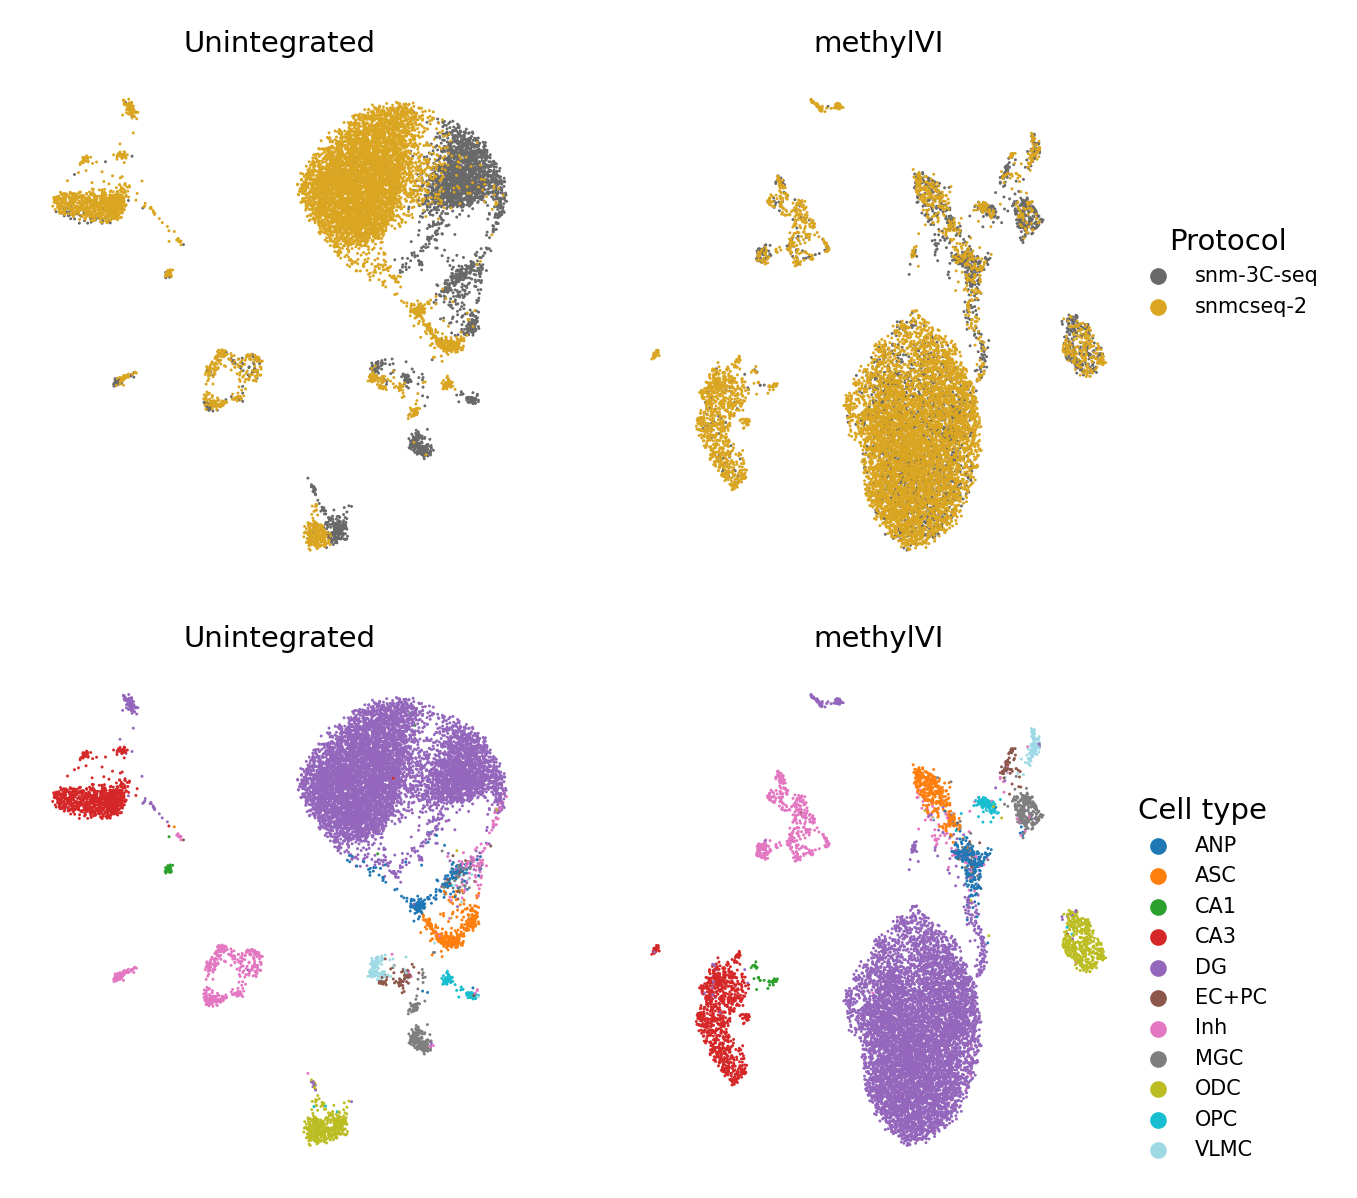

In [16]:
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'legend.markerscale': 0.25})

size = 2

fig, axes = plt.subplots(2, 2, dpi=300)
fig.set_size_inches(120*mm, 120*mm)
platform_palette = ['dimgray', 'goldenrod']
cell_type_palette = "tab20"

sc.pl.embedding(
    mdata,
    color='mCG:Platform',
    ax=axes[0][0],
    show=False,
    legend_loc=None,
    size=size,
    palette=platform_palette,
    basis='pca_umap',
    title="Unintegrated"
)
sc.pl.embedding(
    mdata,
    color='mCG:CoarseType',
    ax=axes[1][0],
    show=False,
    legend_loc=None,
    size=size,
    palette=cell_type_palette,
    basis='pca_umap',
    title="Unintegrated"
)

sc.pl.embedding(
    mdata,
    color='mCG:Platform',
    ax=axes[0][1],
    show=False,
    legend_fontsize=fontsize,
    size=size,
    palette=platform_palette,
    basis='methylVI_umap',
    title='methylVI'
)
sc.pl.embedding(
    mdata,
    color='mCG:CoarseType',
    ax=axes[1][1],
    show=False,
    legend_fontsize=fontsize,
    size=size,
    palette=cell_type_palette,
    basis='methylVI_umap',
    title='methylVI'
)

platform_label_params = axes[0][1].get_legend_handles_labels() 
legend = axes[0][1].get_legend()
legend.set_visible(False)

axes[0][1].legend(
    *platform_label_params,
    loc=(1, 0.5),
    frameon=False,
    markerscale=0.5,
    fontsize=fontsize-2,
    title="Protocol",
)

axes[0][1].invert_yaxis()

cell_type_label_params = axes[1][1].get_legend_handles_labels() 
legend = axes[1][1].get_legend()
legend.set_visible(False)

axes[1][1].legend(
    *cell_type_label_params,
    loc=(1, 0),
    frameon=False,
    markerscale=0.5,
    fontsize=fontsize-2,
    title="Cell type",
)

axes[1][1].invert_yaxis()

axes = [item for row in axes for item in row]

for ax in axes:
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_visible(False)
    ax.set_xlabel("", fontsize=fontsize, labelpad=-5)
    ax.set_ylabel("", fontsize=fontsize, labelpad=-5)
        
fig.savefig("integration_qualitative.pdf", dpi=300, transparent=True)